# 인공지능

## 지도학습 : 문제와 정답을 알려주고 패턴 찾는 것
-  분류분석, 회귀분석
## 비지도학습 : 문제만 알려주고 알고리즘이 알아서 패턴 찾는 것
- 군집분석

# 분류 분석 대표적 알고리즘 : Tree  기반 모델

## 의사결정나무(Decision Tree)
- Decision Tree는 데이터를 분할하여 조건문처럼 분기해가며 예측하는 Tree 기반 모델
- 스무고개와 비슷하게 계속 질문을 던져서 분리

### 장점
- 직관적이고 해석 용이
- feature scaling(변수)이 필요 없음
- 범주형(DecisionTreeClassifier), 수치형(DecisionTreeRegressor) 자료 모두를 분석 가능

### 단점
- 과적합(overfitting)이 잘 일어남(test 데이터에만 fit하게 나타날 수 있음)
- 최적 트리를 찾기 어렵고 시간이 오래 걸릴 수 있음


0. 필요한 라이브러리 로딩
1. 타이타닉 데이터 로딩
2. 데이터 전처리(결측값처리, 이상값 탐지)
3. EDA(탐색적 데이터 분석, 각 컬럼의 데이터 분포, 그래프로 생성, 문자->숫자, 상관관계)
4. Feature Engineering(변수 선택, 새로운 특성 생성, 카테고리 변수와 더미 변수화(one-hot encoding))
5. 최종 선택된 변수를 독립변수(X)와 종속변수(y)로 분리
6. sklearn의 train_test_split을 불러와서 train, test 세트로 분리
7. sklearn에서 DecisionTreeClassifier를 불러와서 모델 훈련
8. test 세트를 모델에 넣어서 예측값 생성(pred)
9. accuracy_score(), classification_report()를 이용해서 모델의 성능 확인

# 0. 필요한 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.impute import SimpleImputer

# 1. 타이타닉 데이터 로딩

In [2]:
data = pd.read_csv('./data/Taitanic_train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 데이터의 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# 데이터의 기초 통계량 확인
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 2. 데이터 전처리(결측값처리, 이상값 탐지)
- 5% 미만 : 행 단위 제거(분석에 큰 영향을 주지 않으므로 단순 제거)
- 5% 이상 30% 미만 : 결측치 대체
    - 수치형 데이터 : 평균, 중앙값, 최빈값(.mode)으로 대체 가능
    - 문자형 데이터 : 최빈값으로 대체 가능
- 30% 이상 50% 미만 : 컬럼의 중요도 판단 후 대체 또는 제거 진행(KNN Imputer,  회귀모델 기반 예측 등으로 판단)
- 50% 이상 : 해당 컬럼 삭제(데이터 손실이 크기 때문에 유의미한 결과를 나타낼 수 없음)

## 데이터 전처리(결측값처리)

In [5]:
# 결측치 차지 비율 확인
data.isna().sum() / len(data) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

### 데이터 결측치 존재 컬럼
- Age            19.865320 : 결측치 대체
-  Cabin          77.104377 : Cabin 컬럼 제거
-  Embarked        0.224467 : 행 단위로 제거하거나 대체

In [6]:
# Age 컬럼 결측치 대치
data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [7]:
# 평균값 대치
data2 = data.copy()
na_idx = data2[data2['Age'].isna()].index
imp_mean = SimpleImputer(strategy='mean')

In [8]:
data['Age'] = imp_mean.fit_transform(data2[['Age']])[:, 0]
data.loc[na_idx]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,29.699118,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,29.699118,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,29.699118,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,29.699118,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,29.699118,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,29.699118,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,29.699118,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,29.699118,0,0,349217,7.8958,NaN,S


In [9]:
# Cabin 컬럼 제거
data = data.drop('Cabin', axis=1)

In [10]:
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [11]:
# Embarked는 최빈값 대체
data['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [12]:
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Embarked'].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [13]:
# 결측치 존재하지 않는 최종 테이블 확인
print(data.isna().sum())
data

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C


## 데이터 전처리(이상값 탐지)

<Axes: >

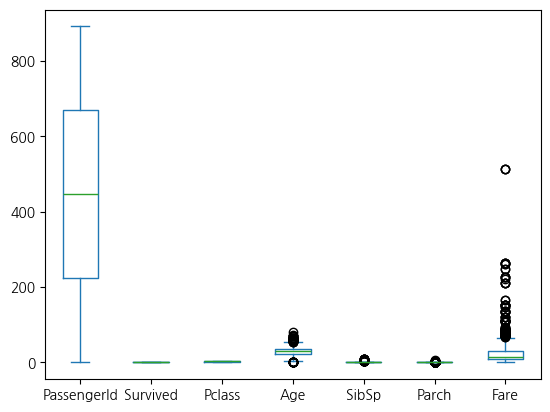

In [14]:
# 전체 컬럼에 대해 숫자형 자료에 대해 박스 플롯 확인
data_num = data[data.describe().columns]
data_num.plot(kind='box')

Age
29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
24.500000      1
0.670000       1
0.420000       1
34.500000      1
74.000000      1
Name: count, Length: 89, dtype: int64


(array([0.0126929 , 0.00592335, 0.00423097, 0.00592335, 0.00126929,
        0.0122698 , 0.01650077, 0.02750128, 0.03088606, 0.01777006,
        0.02750128, 0.10112011, 0.01396219, 0.01988554, 0.01607767,
        0.00888503, 0.01184671, 0.00888503, 0.00676955, 0.00592335,
        0.00634645, 0.00296168, 0.00380787, 0.00338477, 0.00169239,
        0.        , 0.00211548, 0.0004231 , 0.        , 0.0004231 ]),
 array([ 0.42      ,  3.07266667,  5.72533333,  8.378     , 11.03066667,
        13.68333333, 16.336     , 18.98866667, 21.64133333, 24.294     ,
        26.94666667, 29.59933333, 32.252     , 34.90466667, 37.55733333,
        40.21      , 42.86266667, 45.51533333, 48.168     , 50.82066667,
        53.47333333, 56.126     , 58.77866667, 61.43133333, 64.084     ,
        66.73666667, 69.38933333, 72.042     , 74.69466667, 77.34733333,
        80.        ]),
 <BarContainer object of 30 artists>)

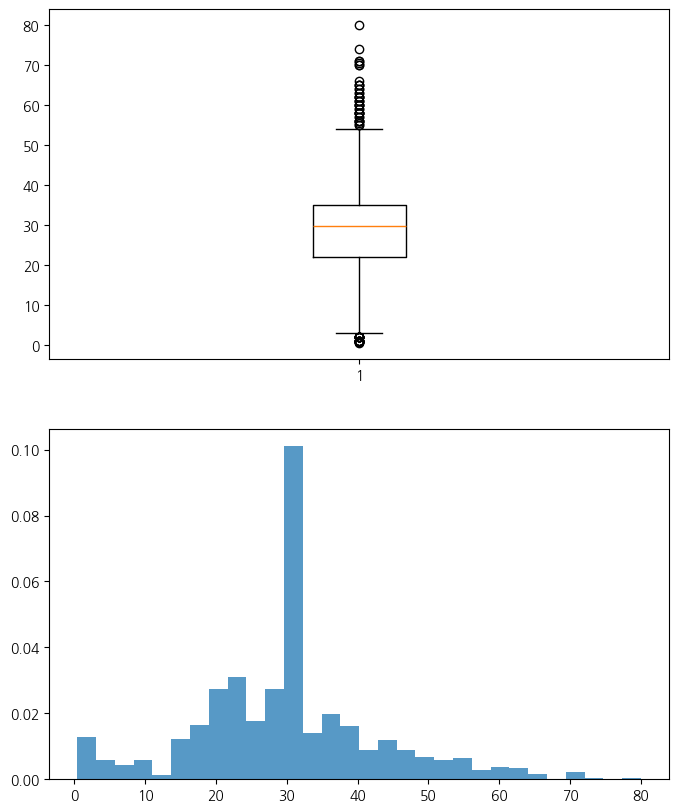

In [15]:
# Age 확인
# uqnique값 확인
# print(data['Age'].unique())
print(data['Age'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['Age'], vert=True)
axes[1].hist(data['Age'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)

[1 0 3 4 2 5 8]
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64


(array([2.55892256, 0.        , 0.        , 0.87962963, 0.        ,
        0.        , 0.        , 0.11784512, 0.        , 0.        ,
        0.        , 0.06734007, 0.        , 0.        , 0.        ,
        0.07575758, 0.        , 0.        , 0.02104377, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.02946128]),
 array([0.        , 0.26666667, 0.53333333, 0.8       , 1.06666667,
        1.33333333, 1.6       , 1.86666667, 2.13333333, 2.4       ,
        2.66666667, 2.93333333, 3.2       , 3.46666667, 3.73333333,
        4.        , 4.26666667, 4.53333333, 4.8       , 5.06666667,
        5.33333333, 5.6       , 5.86666667, 6.13333333, 6.4       ,
        6.66666667, 6.93333333, 7.2       , 7.46666667, 7.73333333,
        8.        ]),
 <BarContainer object of 30 artists>)

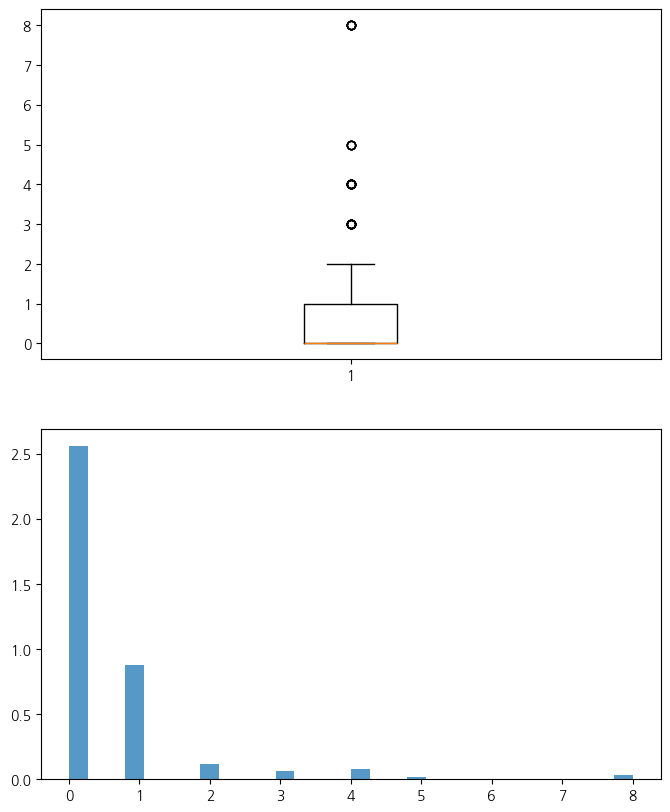

In [16]:
# SibSp(형제자매 수)확인
# uqnique값 확인
print(data['SibSp'].unique())
print(data['SibSp'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['SibSp'], vert=True)
axes[1].hist(data['SibSp'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)

[0 1 2 5 3 4 6]
Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64


(array([3.8047138 , 0.        , 0.        , 0.        , 0.        ,
        0.66217733, 0.        , 0.        , 0.        , 0.        ,
        0.44893378, 0.        , 0.        , 0.        , 0.        ,
        0.02805836, 0.        , 0.        , 0.        , 0.        ,
        0.02244669, 0.        , 0.        , 0.        , 0.        ,
        0.02805836, 0.        , 0.        , 0.        , 0.00561167]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. ]),
 <BarContainer object of 30 artists>)

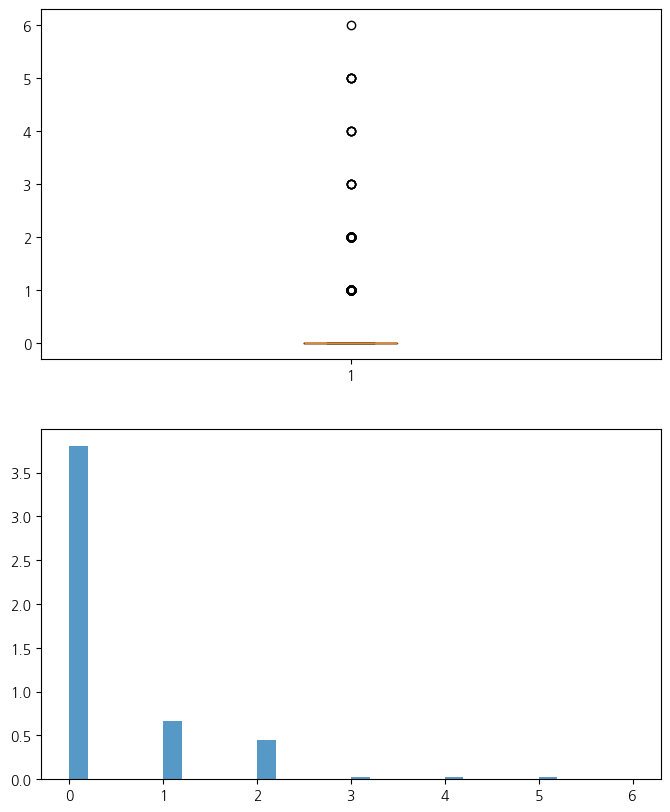

In [17]:
# Parch(부모/자식 수)확인
# uqnique값 확인
print(data['Parch'].unique())
print(data['Parch'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['Parch'], vert=True)
axes[1].hist(data['Parch'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)

Fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
13.8583     1
50.4958     1
5.0000      1
9.8458      1
10.5167     1
Name: count, Length: 248, dtype: int64


(array([0.03259689, 0.01255243, 0.00295738, 0.00295738, 0.00315454,
        0.00085435, 0.00072291, 0.00072291, 0.00059148, 0.00013144,
        0.        , 0.        , 0.0003286 , 0.00026288, 0.00013144,
        0.00039432, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00019716]),
 array([  0.     ,  17.07764,  34.15528,  51.23292,  68.31056,  85.3882 ,
        102.46584, 119.54348, 136.62112, 153.69876, 170.7764 , 187.85404,
        204.93168, 222.00932, 239.08696, 256.1646 , 273.24224, 290.31988,
        307.39752, 324.47516, 341.5528 , 358.63044, 375.70808, 392.78572,
        409.86336, 426.941  , 444.01864, 461.09628, 478.17392, 495.25156,
        512.3292 ]),
 <BarContainer object of 30 artists>)

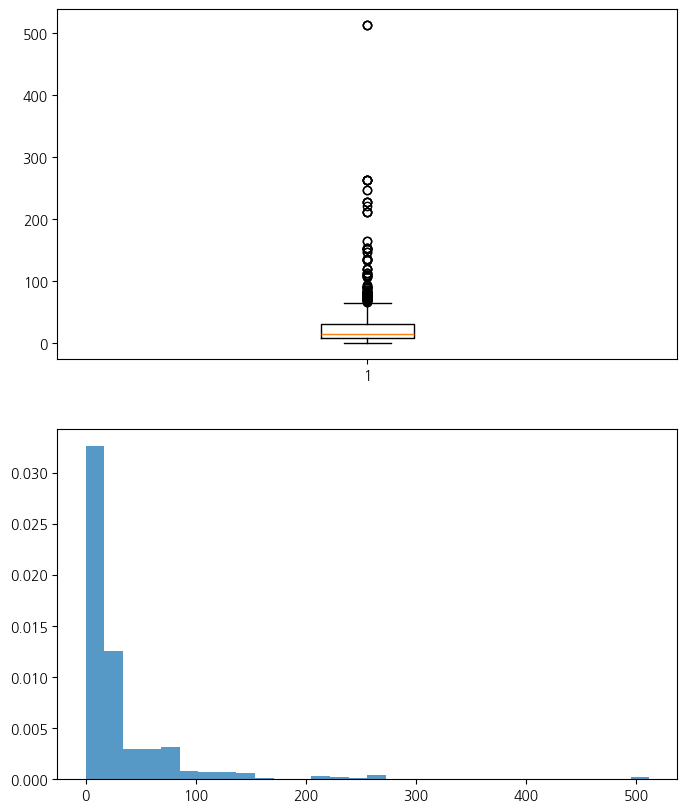

In [18]:
# Fare 확인
# uqnique값 확인
# print(data['Fare'].unique())
print(data['Fare'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['Fare'], vert=True)
axes[1].hist(data['Fare'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)

In [19]:
fare_desc = data['Fare'].describe()
print(fare_desc, type(fare_desc))

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64 <class 'pandas.core.series.Series'>


In [20]:
# 이상치가 1사분면과 평균보다 이상인 경우만 존재
upper_bound = fare_desc['75%'] + (1.5 * (fare_desc['75%'] - fare_desc['25%']))
print(upper_bound)

65.6344


In [21]:
# 이상치 확인
outlier = data[data['Fare'] > upper_bound]
outlier

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000000,3,2,19950,263.0000,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,29.699118,1,0,PC 17569,146.5208,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000000,1,0,PC 17604,82.1708,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000000,1,0,PC 17572,76.7292,C
...,...,...,...,...,...,...,...,...,...,...,...
846,847,0,3,"Sage, Mr. Douglas Bullen",male,29.699118,8,2,CA. 2343,69.5500,S
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,29.699118,1,0,17453,89.1042,C
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.000000,1,1,36928,164.8667,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,29.699118,8,2,CA. 2343,69.5500,S


In [22]:
# 선실등급별 요금의 차이 확인
# 1등급 선실의 요금이 기이하게 높은 것을 확인
fare_desc_pclass = data[['Pclass', 'Fare']].groupby('Pclass').describe()
fare_desc_pclass

Fare                                                              
        count       mean        std  min       25%      50%   75%       max
Pclass                                                                     
1       216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292
2       184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000
3       491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500

In [23]:
fare_desc_pclass.columns

MultiIndex([('Fare', 'count'),
            ('Fare',  'mean'),
            ('Fare',   'std'),
            ('Fare',   'min'),
            ('Fare',   '25%'),
            ('Fare',   '50%'),
            ('Fare',   '75%'),
            ('Fare',   'max')],
           )

In [24]:
pl_upper_bound = fare_desc_pclass.loc[1, ('Fare',   '75%')] + (1.5 * (fare_desc_pclass.loc[1, ('Fare',   '75%')] - fare_desc_pclass.loc[1, ('Fare',   '25%')]))
pl_upper_bound

np.float64(187.364075)

In [25]:
data['Fare'].max()

np.float64(512.3292)

In [26]:
pl_outlier = data[data['Fare'] > pl_upper_bound]
pl_outlier

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000000,3,2,19950,263.0000,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.000000,3,2,19950,263.0000,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.000000,0,1,PC 17558,247.5208,C
258,259,1,1,"Ward, Miss. Anna",female,35.000000,0,0,PC 17755,512.3292,C
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.000000,0,1,PC 17558,247.5208,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.000000,2,2,PC 17608,262.3750,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.000000,3,2,19950,263.0000,S
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.000000,0,2,113503,211.5000,C
380,381,1,1,"Bidois, Miss. Rosalie",female,42.000000,0,0,PC 17757,227.5250,C
438,439,0,1,"Fortune, Mr. Mark",male,64.000000,1,4,19950,263.0000,S


In [27]:
pl_outlier['Ticket'].value_counts()

Ticket
19950       4
PC 17757    4
24160       3
PC 17755    3
PC 17608    2
PC 17558    2
113503      1
PC 17483    1
Name: count, dtype: int64

891


<Axes: >

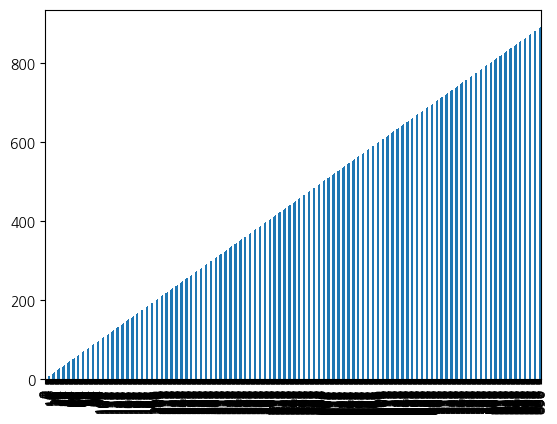

In [28]:
# PassengerId 확인
# unique 값 확인
print(len(data['PassengerId'].unique()))

# 인덱스와 같이 작용 
# 이상치는 없는 것으로 판단
data['PassengerId'].plot(kind='bar')

[0 1]
Survived
0    549
1    342
Name: count, dtype: int64


<Axes: ylabel='count'>

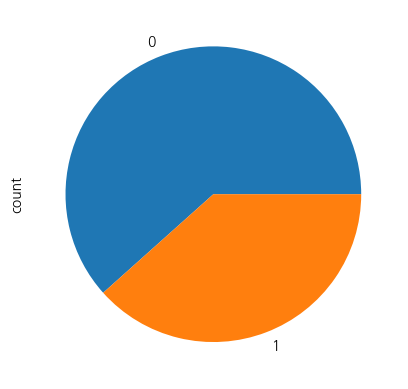

In [29]:
# Survived 확인
# uqnique값 확인
print(data['Survived'].unique())
print(data['Survived'].value_counts())

# 파이 그래프 생성
# 이상치는 없는 것으로 판단
data['Survived'].value_counts().plot(kind='pie')


[3 1 2]
Pclass
3    491
1    216
2    184
Name: count, dtype: int64


<Axes: xlabel='Pclass'>

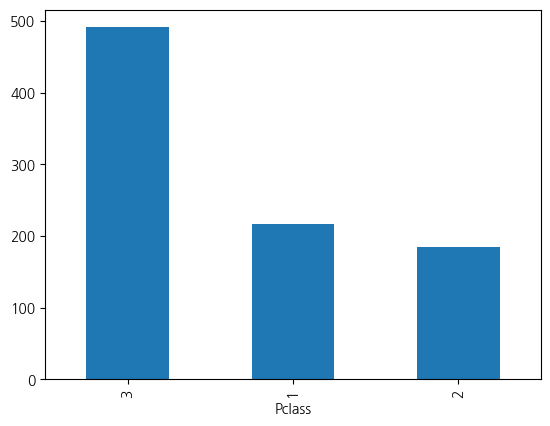

In [30]:
# Pclass 확인
# uqnique값 확인
print(data['Pclass'].unique())
print(data['Pclass'].value_counts())

# 막대 그래프 생성
# 이상치는 없는 것으로 판단
data['Pclass'].value_counts().plot(kind='bar')


In [31]:
# Name 확인
# uqnique값 확인
# 이상치 없는 것으로 판단
print(len(data['Name'].unique()))
print(data['Name'].value_counts())

891
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
Uruchurtu, Don. Manuel E                               1
Spencer, Mrs. William Augustus (Marie Eugenie)         1
Glynn, Miss. Mary Agatha                               1
Wheadon, Mr. Edward H                                  1
Meyer, Mr. Edgar Joseph                                1
Name: count, Length: 891, dtype: int64


['male' 'female']
Sex
male      577
female    314
Name: count, dtype: int64


<Axes: ylabel='count'>

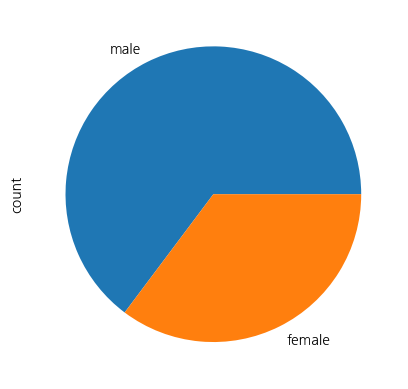

In [32]:
# Sex 확인
# uqnique값 확인
print(data['Sex'].unique())
print(data['Sex'].value_counts())

# 파이차트 생성
data['Sex'].value_counts().plot(kind='pie')

Ticket
347082             7
1601               7
CA. 2343           7
3101295            6
CA 2144            6
                  ..
SOTON/OQ 392076    1
211536             1
112053             1
111369             1
392091             1
Name: count, Length: 681, dtype: int64


<Axes: xlabel='Ticket'>

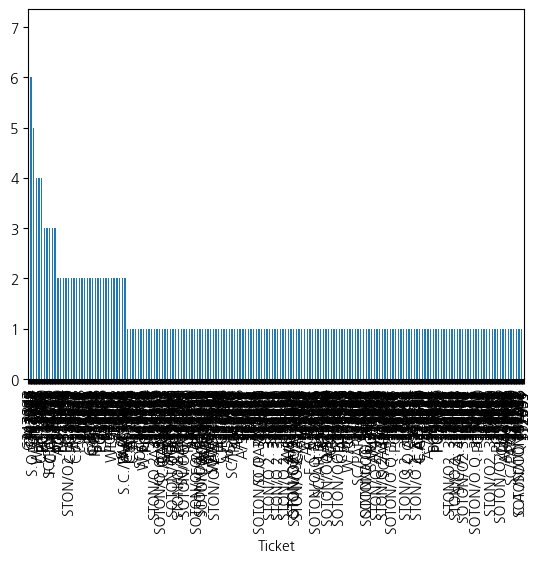

In [33]:
# Ticket 확인
# uqnique값 확인
# print(data['Ticket'].unique())
print(data['Ticket'].value_counts())

# 막대그래프 생성
data['Ticket'].value_counts().plot(kind='bar')

In [34]:
data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.699118,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


In [35]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [36]:
# 선실등급별 생존율 확인
data[['Pclass', 'Survived']].groupby('Pclass').mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [37]:
# 성별별 생존율 확인
data[['Sex', 'Survived']].groupby('Sex').mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [38]:
# 형제자매 수에 따른 생존율 확인
data[['SibSp', 'Survived']].groupby('SibSp').mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [39]:
# 부모자식 수에 따른 생존율 확인
data[['Parch', 'Survived']].groupby('Parch').mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


In [40]:
# 탑승지에 따른 생존율 확인
data[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


In [41]:
# 나이에 따른 생존율 확인
# 구간으로 나누어 확인
data['Age'].value_counts()

Age
29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
24.500000      1
0.670000       1
0.420000       1
34.500000      1
74.000000      1
Name: count, Length: 89, dtype: int64

In [42]:
data['Age'].max()

np.float64(80.0)

In [43]:
data['Age'] = pd.cut(data['Age'],
                     bins=[0,10,20,30,40,50,60,70,80,90],
                     labels=['under10s','10s','20s','30s','40s','50s','60s','70s','80s'], 
                    right=False)

In [44]:
data[data['Age'] == '80s']

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
630,1,1,male,80s,0,0,30.0,S


In [45]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,20s,1,0,7.2500,S
1,1,1,female,30s,1,0,71.2833,C
2,1,3,female,20s,0,0,7.9250,S
3,1,1,female,30s,1,0,53.1000,S
4,0,3,male,30s,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,20s,0,0,13.0000,S
887,1,1,female,10s,0,0,30.0000,S
888,0,3,female,20s,1,2,23.4500,S
889,1,1,male,20s,0,0,30.0000,C


In [46]:
data[['Survived', 'Age']].groupby('Age').mean()

C:\Users\Admin\AppData\Local\Temp\ipykernel_15172\1401584837.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data[['Survived', 'Age']].groupby('Age').mean()


,Survived
Age,
under10s,0.612903
10s,0.401961
20s,0.324937
30s,0.437126
40s,0.382022
50s,0.416667
60s,0.315789
70s,0.000000
80s,1.000000


In [47]:
data[['Survived', 'Embarked']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


In [48]:
# 형제자매수 및 부모자식수는 굳이 따로 있을 필요가 없다고 생각
# Family 컬럼으로 하나의 컬럼으로 재생성
data['Family'] = data['SibSp'] + data['Parch']
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,0,3,male,20s,1,0,7.2500,S,1
1,1,1,female,30s,1,0,71.2833,C,1
2,1,3,female,20s,0,0,7.9250,S,0
3,1,1,female,30s,1,0,53.1000,S,1
4,0,3,male,30s,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...,...
886,0,2,male,20s,0,0,13.0000,S,0
887,1,1,female,10s,0,0,30.0000,S,0
888,0,3,female,20s,1,2,23.4500,S,3
889,1,1,male,20s,0,0,30.0000,C,0


In [49]:
data = data.drop(['SibSp','Parch'], axis=1)

In [50]:
data[['Survived', 'Family']].groupby('Family').mean()

,Survived
Family,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [51]:
data[['Pclass', 'Sex', 'Age', 'Survived']].groupby(['Pclass', 'Sex', 'Age']).mean().sort_values(by='Survived', ascending=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15172\2612514985.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data[['Pclass', 'Sex', 'Age', 'Survived']].groupby(['Pclass', 'Sex', 'Age']).mean().sort_values(by='Survived', ascending=False)


Survived
Pclass Sex    Age               
1      female 10s       1.000000
              30s       1.000000
              60s       1.000000
              40s       1.000000
       male   under10s  1.000000
2      female 10s       1.000000
              under10s  1.000000
3      female 60s       1.000000
2      male   under10s  1.000000
1      male   80s       1.000000
       female 20s       0.960000
2      female 30s       0.941176
1      female 50s       0.916667
2      female 40s       0.900000
              20s       0.888889
              50s       0.833333
3      female 20s       0.547945
              10s       0.541667
              under10s  0.523810
1      male   30s       0.521739
3      female 30s       0.437500
1      male   10s       0.400000
3      male   under10s  0.380952
1      male   40s       0.375000
              20s       0.358974
2      male   60s       0.333333
1      male   50s       0.266667
3      male   30s       0.150943
              20s       0.127551
2      male   40s       0.125000
1      male   60s       0.100000
2      male   10s       0.100000
              30s       0.096774
3      male   10s       0.095238
              40s       0.080000
2      male   20s       0.054054
1      female under10s  0.000000
       male   70s       0.000000
2      male   50s       0.000000
              70s       0.000000
3      female 40s       0.000000
       male   50s       0.000000
              60s       0.000000
              70s       0.000000
1      female 70s            NaN
              80s            NaN
2      female 60s            NaN
              70s            NaN
              80s            NaN
       male   80s            NaN
3      female 50s            NaN
              70s            NaN
              80s            NaN
       male   80s            NaN

## 문자데이터 숫자로 인코딩

In [52]:
data = data.drop('Fare', axis=1)

In [53]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Embarked', 'Family'], dtype='object')

In [54]:
data = pd.get_dummies(data, columns=['Sex', 'Age', 'Embarked','Family'])

# 독립변수(문제, X), 종속변수()

In [55]:
X = data.drop('Survived', axis=1)
y = data['Survived']

In [56]:
X

,Pclass,Sex_female,Sex_male,Age_under10s,Age_10s,Age_20s,Age_30s,Age_40s,Age_50s,Age_60s,...,Embarked_S,Family_0,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_10
0,3,False,True,False,False,True,False,False,False,False,...,True,False,True,False,False,False,False,False,False,False
1,1,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,3,True,False,False,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
3,1,True,False,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,False,False,False
4,3,False,True,False,False,False,True,False,False,False,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,False,True,False,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
887,1,True,False,False,True,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
888,3,True,False,False,False,True,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
889,1,False,True,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [57]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

# 분석 모델 선택 및 분석

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [63]:
dtc = DecisionTreeClassifier(random_state=777)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

0.8208955223880597
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       174
           1       0.77      0.70      0.73        94

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268

